## Can a Machine Learning Model Predict Whether a Hotel Booking Would be Canceled?


*The goal of this project is to build a machine learning model than can predict booking cancellations based on various attributes of reservations. This data set contains booking information for a city hotel and a resort hotel, and includes information such as when the booking was made, length of stay, the number of adults, children, and/or babies, and the number of available parking spaces, among other things.*

## The Data


In [ ]:
# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBRFClassifier

In [ ]:
#read the CSV file
df = pd.read_csv('/content/hotel_bookings.csv')

pd.get_option("display.max_columns",None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

*This CSV file has 120 K rows of data covering a wide variety of attributes.*

*When we look at the date columns, we can see that the data ranges from mid-2015 to late-2017.*

*In order to predict the cancelation, we need to determine what columns correlate with it*

In [ ]:
 # shows corralation with is_canceled column
 df.corr()['is_canceled']

<ipython-input-30-2749ec954e7a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['is_canceled']


is_canceled                       1.000000
lead_time                         0.293123
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month        -0.006130
stays_in_weekend_nights          -0.001791
stays_in_week_nights              0.024765
adults                            0.060017
children                          0.005048
babies                           -0.032491
is_repeated_guest                -0.084793
previous_cancellations            0.110133
previous_bookings_not_canceled   -0.057358
booking_changes                  -0.144381
agent                            -0.083114
company                          -0.020642
days_in_waiting_list              0.054186
adr                               0.047557
required_car_parking_spaces      -0.195498
total_of_special_requests        -0.234658
Name: is_canceled, dtype: float64

*We can see the columns with the strongest correlation with the cancelation are lead time, car spaces and special requests.*

## Graphs showing the correlations

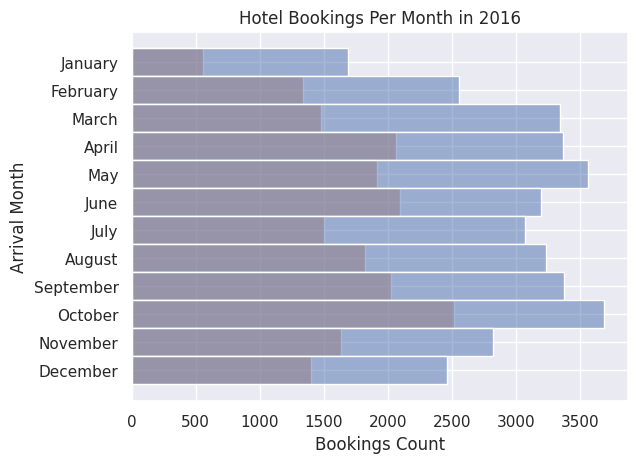

In [ ]:
# shows cancellations and bookings together in a graph

df = pd.read_csv('/content/hotel_bookings.csv')
sns.set()

# get data only from 2016
df2 = df.loc[df['arrival_date_year'] == 2016]
hi = sns.histplot(y=df2['arrival_date_month'], hue=df2['is_canceled'],alpha=0.5, legend=False)
hi.set(ylabel ="Arrival Month", xlabel = "Bookings Count", title ='Hotel Bookings Per Month in 2016')

plt.show()

*In the above graph we can see all cancellations and bookings in the year 2016. This shows about ~40% of all bookings are getting canceled.*

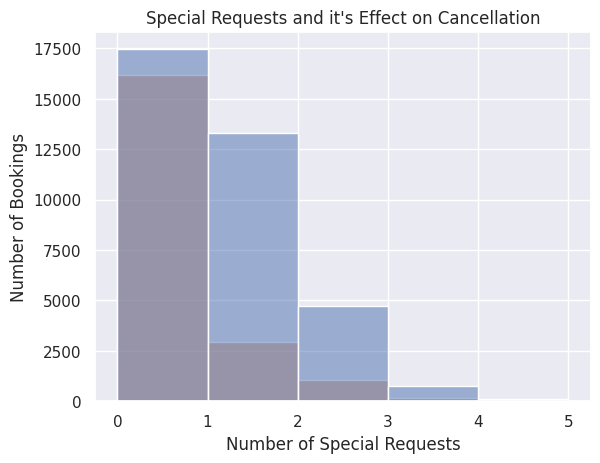

In [ ]:
#shows negative correlation with cancelation in a graph using a histogram

hi = sns.histplot(x=df2['total_of_special_requests'], hue=df2['is_canceled'],alpha=0.5,bins=5, legend=False)
hi.set(ylabel ="Number of Bookings", xlabel = "Number of Special Requests", title ="Special Requests and it's Effect on Cancellation")
plt.show()

*The above graph shows the negative correlation between cancellations and # of special requests. In the first column we can see that cancellation is about 80% with no special requests, but when we get 1 or more special request we can see the percentaion of cancelations signifantly drop.*

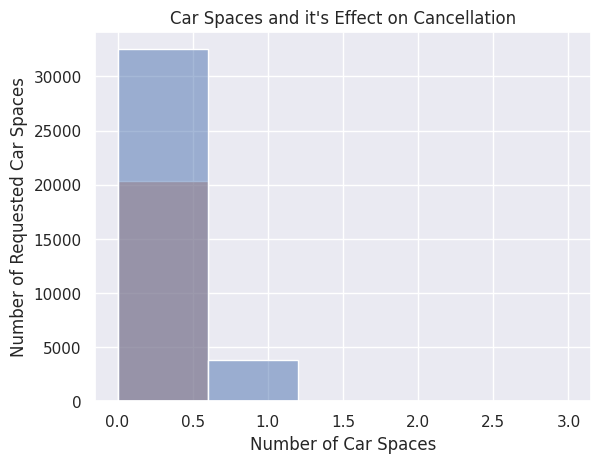

In [ ]:
#shows negative correlation with cancelation with graph using histogram

hi1 = sns.histplot(x=df2['required_car_parking_spaces'], hue=df2['is_canceled'],alpha=0.5,bins=5, legend=False)
hi1.set(ylabel ="Number of Requested Car Spaces", xlabel = "Number of Car Spaces", title ="Car Spaces and it's Effect on Cancellation")
plt.show()

*We can see the same correlation with car spaces and speical requests as shown above with this graph. In the first column we can see cancellations at 60% with no car space, but they significantly drop with more car spaces.*


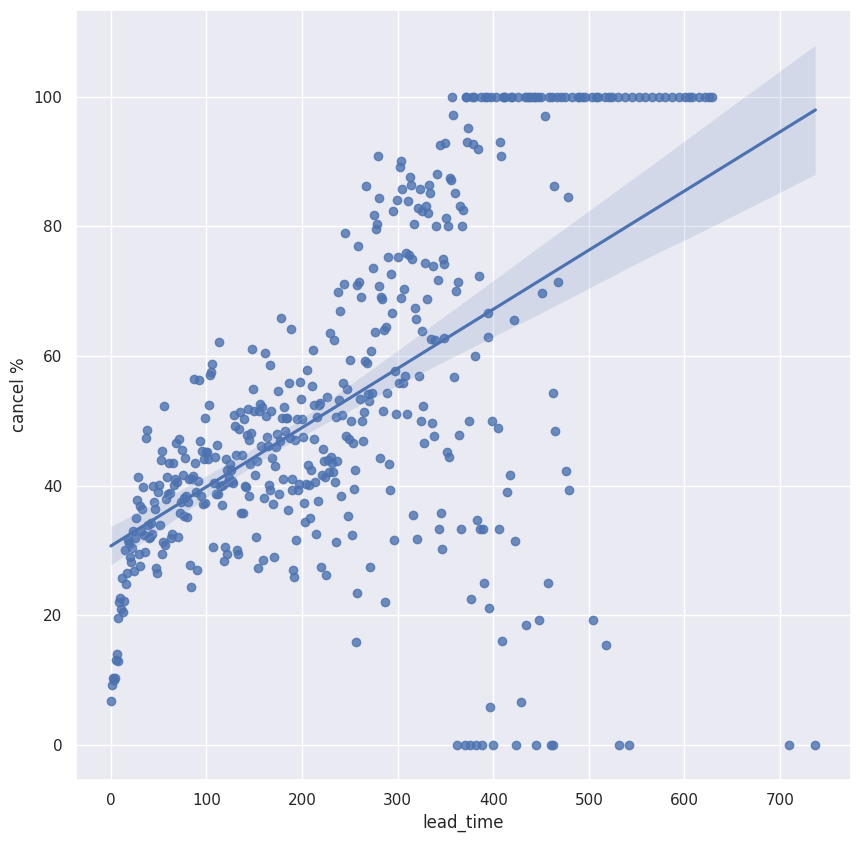

In [ ]:
# this graph finds the chance of a booking being cancelled by looking at lead time
# This code first creates a list of all unique lead times
# it then loops through all of the times and gathers all of the coresponding lead time and takes the mean
# because all the values are 1 and 0, this method creates percentages for all the values of lead time

#creates a dummy data fram
df2 = pd.read_csv('/content/hotel_bookings.csv')

pd.get_option("display.max_columns",None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#takes the unique lead times and puts them in a list
a = df2['lead_time'].unique()
a = list(a)

#change list into data frame column
a = pd.DataFrame(a)
a['lead'] = a[0]

#creates a list of averge cancelation % per lead time
temp = []
for v in a['lead']:
  temp.append(df2.loc[df2['lead_time'] == v ]['is_canceled'].mean())

#change list into data frame column
x = pd.Series(temp, name='average')
x = pd.DataFrame(x)
x[0] = a[0]

#merges both df to create a common one
new = pd.merge(a, x, on=0)
new = new.drop(0, axis=1)

#create new columns for the data
new['lead_time'] = new['lead']
new['cancel %'] = new['average'] *100

#drops old columns
new = new.drop('lead', axis=1)
new = new.drop('average', axis=1)

#creates graph
plt.figure(figsize=(10,10))
sns.regplot(x=new['lead_time'], y=new['cancel %']) #creates graph
plt.show()

*This graph shows the positve correlation between lead time of the booking and cancellations. We can see by the line of best fit that there is a significant positive correlation between lead time and cancelations*

## Machine Learning


In [ ]:
df = pd.read_csv('/content/hotel_bookings.csv')

pd.get_option("display.max_columns",None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#drops text or unnecessary columns
df.drop(['agent', 'company', 'country', 'market_segment', 'distribution_channel', 'customer_type', 'reservation_status', 'reservation_status_date', 'reserved_room_type', 'assigned_room_type'], axis=1, inplace=True)

#changes months into numbers due to them being text
d = {'July':'7', 'August':'8', 'September':'9', 'October':'10', 'November':'11', 'December':'12', 'January':'1',
 'February':'2', 'March':'3', 'April':'4', 'May':'5', 'June':'6'}
df.arrival_date_month = df.arrival_date_month.map(d)

#convert the number months into int values
l = ['arrival_date_month']
for i in l:
    df[i] = pd.to_numeric(df[i],errors='coerce')
df = df.fillna(df.median(numeric_only=True))

In [ ]:
#create X ande y data frames
y = df['is_canceled']
x = pd.get_dummies(df)

# do one=hot encoding
usedf = pd.get_dummies(df)
x.drop(['is_canceled'], axis=1, inplace=True)

In [ ]:
#splits the data into testing a traing sets
X_train, X_test, y_train, y_test = train_test_split(x,y)

In [ ]:
def cla(m):
  m.fit(X_train, y_train) #custon function to run diffrent models faster
  return m.score(X_test, y_test)

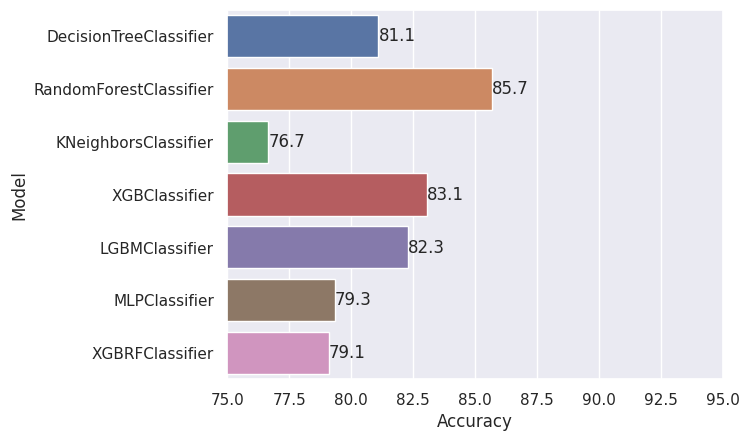

In [ ]:
#list of models and results
mlist = ['DecisionTreeClassifier','RandomForestClassifier','KNeighborsClassifier','XGBClassifier','LGBMClassifier','MLPClassifier','XGBRFClassifier' ]
alist = []

#runs the above function on all models in the mlist
for i in mlist:
  alist.append(eval(f'cla({i}())'))

#merges the two lists into a data frame
gdf = pd.DataFrame(list(zip(mlist, alist)), columns =['Model', 'Accuracy'])

fig, ax = plt.subplots()
ax2 = sns.barplot(y=gdf['Model'], x=gdf['Accuracy']*100)
ax2.bar_label(ax2.containers[0], fmt='%.1f')
ax.set_xlim(75 , 95)
plt.show()

*This graph shows that the Random Forest Model is best suited for this data set and topic,*

In [ ]:
#find out best depth by using GridsearchCV

model2 = RandomForestClassifier()
params = {'max_depth':[_ for _ in range(1,10)]}
grid_reg = GridSearchCV(model2, params)
grid_reg.fit(X_train, y_train)
print(grid_reg.best_params_)

{'max_depth': 9}


In [ ]:
#find out best depth by using GridsearchCV

model2 = RandomForestClassifier(max_depth=9)
params = {'n_estimators':[2, 1, 75]}
grid_reg = GridSearchCV(model2, params)
grid_reg.fit(X_train, y_train)
print(grid_reg.best_params_)

{'n_estimators': 75}


*In the above 2 cells, we can see that the best hyper parameters are max depth: 9 and n estimators:75*

In [ ]:
#create model with the best hyper paramaters and get predictions

model = RandomForestClassifier(max_depth=9, n_estimators=75)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions  = model.predict_proba(X_test)

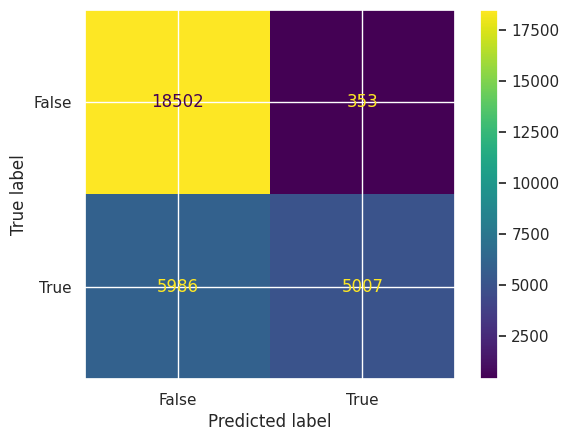

In [ ]:
 # create confution matrix to show errors in the models predictions

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

*This shows the confusion matrix that shows the number of values the model got correct. We can also see that this model makes a lot of false negatives.*

In [ ]:
#Get the presision score of the model

precision_score(y_test, y_pred)

0.9341417910447761

We can see that the ML Random Forest has a presision score of 95%

## Keras

After  learning how to make neural networks, I wanted to see if a network could compete with the Random Forest Model.

In [ ]:
#creates a seqential neural net
model = Sequential()
num_cols = X_train.shape[1]

#adds 3 hidden layers
model.add(Dense(216, input_shape=(num_cols,), activation='relu')) # specify num of cols as input_shape for 1st layer only
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 216)               6264      
                                                                 
 dense_4 (Dense)             (None, 64)                13888     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 20,217
Trainable params: 20,217
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#compiles and create Neural Network

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=180, validation_split=0.5 ,callbacks=[early_stopping_monitor])
model.evaluate(X_test, y_test)

Epoch 1/180
1400/1400 [==============================] - 13s 8ms/step - loss: 2.4580 - accuracy: 0.6321 - val_loss: 3.3678 - val_accuracy: 0.6292
Epoch 2/180
1400/1400 [==============================] - 6s 4ms/step - loss: 1.4433 - accuracy: 0.6836 - val_loss: 2.5148 - val_accuracy: 0.4057
Epoch 3/180
1400/1400 [==============================] - 6s 4ms/step - loss: 1.0808 - accuracy: 0.6910 - val_loss: 0.7266 - val_accuracy: 0.7590
Epoch 4/180
1400/1400 [==============================] - 6s 4ms/step - loss: 0.8273 - accuracy: 0.7085 - val_loss: 2.3015 - val_accuracy: 0.6500
Epoch 5/180
1400/1400 [==============================] - 5s 4ms/step - loss: 0.7007 - accuracy: 0.7199 - val_loss: 1.0585 - val_accuracy: 0.7448
Epoch 6/180
1400/1400 [==============================] - 6s 4ms/step - loss: 0.6357 - accuracy: 0.7247 - val_loss: 0.7894 - val_accuracy: 0.7591
Epoch 7/180
1400/1400 [==============================] - 5s 3ms/step - loss: 0.5833 - accuracy: 0.7329 - val_loss: 0.6854 - val_a

[0.4212900400161743, 0.7981774210929871]

*We can see that the accuracy of the neural Network is ~80% on average.*

## The Conclusion

*The goal was to see if I could build a machine-learning model that could predict if a booking would be cancelled or not. The Random Forest Model has achieved this goal. The Random Forest model also had a higher accuracy than the neural network. The RF model is able to predict cancellations with a precision score of 95% while the neural Net only had a accuracy of 80% making it better suited for the task.*


*This Machine Learning model helps answer my question and solves a problem in the real world. Using this ML model, hotels could identify and predict bookings with a very high likelihood of cancellation.*